<a href="https://colab.research.google.com/github/hruthikgithubrit/Personalized-Tutor/blob/main/Transformer_based_CodeT5_for_Code_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
!pip install evaluate
!pip install datasets
!pip install transformers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import json
from tqdm import tqdm
import torch
import evaluate
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import gc
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Force garbage collection more aggressively
def force_gc():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [3]:
print("="*50)
print("PART 1: DATASET ANALYSIS")
print("="*50)

PART 1: DATASET ANALYSIS


In [4]:
# Load the dataset
print("Loading the dataset...")
dataset = load_dataset("deepmind/code_contests", streaming=False)

Loading the dataset...


README.md:   0%|          | 0.00/13.0k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

(…)-00000-of-00039-e991a271dbfa9925.parquet:   0%|          | 0.00/180M [00:00<?, ?B/s]

(…)-00001-of-00039-e092fe56fda18715.parquet:   0%|          | 0.00/209M [00:00<?, ?B/s]

(…)-00002-of-00039-9cea23812e920e41.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

(…)-00003-of-00039-e3822fccad6e083a.parquet:   0%|          | 0.00/181M [00:00<?, ?B/s]

(…)-00004-of-00039-cefe355b4667b27e.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

(…)-00005-of-00039-b7580d2d846c2136.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

(…)-00006-of-00039-65184bb9f7d61fde.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

(…)-00007-of-00039-05785de21e8b8429.parquet:   0%|          | 0.00/172M [00:00<?, ?B/s]

(…)-00008-of-00039-7246e6b7423b404f.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

(…)-00009-of-00039-b8c920f6629b57b2.parquet:   0%|          | 0.00/205M [00:00<?, ?B/s]

(…)-00010-of-00039-6de28ba20654f69b.parquet:   0%|          | 0.00/178M [00:00<?, ?B/s]

(…)-00011-of-00039-5de236be5188959d.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

(…)-00012-of-00039-da9476a39a1bdbb7.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

(…)-00013-of-00039-30b8c3829ee3b962.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

(…)-00014-of-00039-dc3ebb07a3cba8e4.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

(…)-00015-of-00039-19ccd7331d695677.parquet:   0%|          | 0.00/179M [00:00<?, ?B/s]

(…)-00016-of-00039-bf38b0908b322307.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

(…)-00017-of-00039-ae5533a2f822e6ef.parquet:   0%|          | 0.00/169M [00:00<?, ?B/s]

(…)-00018-of-00039-8c793837880f5507.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

(…)-00019-of-00039-d688fad5ee604390.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

(…)-00020-of-00039-5d59387098675b73.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

(…)-00021-of-00039-b257bf03d6876780.parquet:   0%|          | 0.00/181M [00:00<?, ?B/s]

(…)-00022-of-00039-1cfd39fa43c1917c.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00023-of-00039-d078bcb55e45cbf0.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

(…)-00024-of-00039-f4e3da0e5661e6d1.parquet:   0%|          | 0.00/181M [00:00<?, ?B/s]

(…)-00025-of-00039-3f6ebfbaba5f4c70.parquet:   0%|          | 0.00/206M [00:00<?, ?B/s]

(…)-00026-of-00039-7d4898300894cbbe.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

(…)-00027-of-00039-f8196766547533a2.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

(…)-00028-of-00039-79a302af3c924863.parquet:   0%|          | 0.00/179M [00:00<?, ?B/s]

(…)-00029-of-00039-2b6615897d038115.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

(…)-00030-of-00039-4135cc54050afc22.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

(…)-00031-of-00039-40309dd907c042b7.parquet:   0%|          | 0.00/181M [00:00<?, ?B/s]

(…)-00032-of-00039-7b7d2068a3d9c359.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

(…)-00033-of-00039-53b0f749aacff9c1.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

(…)-00034-of-00039-a36ff0bff7d2a76f.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

(…)-00035-of-00039-d28f9be60314601f.parquet:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)-00036-of-00039-146e1a11c054aeab.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

(…)-00037-of-00039-995207c374a4e6f2.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

(…)-00038-of-00039-96a59dd6a98cd075.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

(…)-00000-of-00001-9c49eeff30aacaa8.parquet:   0%|          | 0.00/63.1M [00:00<?, ?B/s]

(…)-00000-of-00001-5e672c5751f060d3.parquet:   0%|          | 0.00/51.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13328 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/165 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/117 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

In [5]:
# Check the splits in the dataset
print(f"\nDataset splits: {dataset.keys()}")

# Get sample counts for each split
for split in dataset.keys():
    print(f"Number of samples in {split}: {len(dataset[split])}")


Dataset splits: dict_keys(['train', 'test', 'valid'])
Number of samples in train: 13328
Number of samples in test: 165
Number of samples in valid: 117


In [6]:
# Function to analyze source and difficulty distribution
def analyze_problem_distribution(dataset_split):
    # Take a smaller sample for analysis
    sample_size = min(1000, len(dataset_split))
    sample = dataset_split.select(range(sample_size))

    # Source distribution
    source_counts = Counter(sample['source'])
    source_names = dataset_split.features['source'].names
    source_dist = {source_names[src]: count for src, count in source_counts.items()}

    # Difficulty distribution
    difficulty_counts = Counter(sample['difficulty'])
    difficulty_names = dataset_split.features['difficulty'].names
    difficulty_dist = {difficulty_names[diff]: count for diff, count in difficulty_counts.items()}

    # Language distribution in solutions
    languages = []
    for solutions in sample['solutions']:
        for solution in solutions['language']:
            languages.append(solution)

    language_names = dataset_split.features['solutions'].feature['language'].names
    language_counts = Counter(languages)
    language_dist = {language_names[lang]: count for lang, count in language_counts.items()}

    return source_dist, difficulty_dist, language_dist

In [7]:
# Analyze train set
print("\nAnalyzing problem distribution...")
train_source, train_difficulty, train_language = analyze_problem_distribution(dataset['train'])



Analyzing problem distribution...


In [8]:
# Print results
print("\nSource Distribution (Train):")
for source, count in sorted(train_source.items(), key=lambda x: x[1], reverse=True):
    print(f"{source}: {count}")

print("\nDifficulty Distribution (Train):")
for diff, count in sorted(train_difficulty.items(), key=lambda x: x[1], reverse=True):
    print(f"{diff}: {count}")

print("\nLanguage Distribution in Solutions (Train):")
for lang, count in sorted(train_language.items(), key=lambda x: x[1], reverse=True):
    print(f"{lang}: {count}")



Source Distribution (Train):
CODEFORCES: 607
AIZU: 151
ATCODER: 94
HACKEREARTH: 88
CODECHEF: 60

Difficulty Distribution (Train):
UNKNOWN_DIFFICULTY: 333
D: 125
B: 116
C: 108
A: 106
E: 80
F: 42
EXTERNAL: 29
MEDIUM: 21
G: 13
H: 6
EASY: 5
I: 5
HARD: 5
J: 3
O: 1
K: 1
M: 1

Language Distribution in Solutions (Train):
CPP: 133824
PYTHON3: 101736
JAVA: 68541
PYTHON: 20814


In [9]:
# Analyze description lengths and solution counts
def analyze_text_and_solutions(dataset_split):
    # Take a smaller sample for analysis
    sample_size = min(1000, len(dataset_split))
    sample = dataset_split.select(range(sample_size))

    desc_lengths = [len(item) for item in sample['description']]
    solution_counts = [len(item['solution']) for item in sample['solutions']]

    # Calculate statistics
    avg_desc_length = np.mean(desc_lengths)
    median_desc_length = np.median(desc_lengths)
    max_desc_length = max(desc_lengths)
    min_desc_length = min(desc_lengths)

    avg_solutions = np.mean(solution_counts)
    median_solutions = np.median(solution_counts)
    max_solutions = max(solution_counts)
    min_solutions = min(solution_counts)

    return {
        'desc_lengths': desc_lengths,
        'solution_counts': solution_counts,
        'avg_desc_length': avg_desc_length,
        'median_desc_length': median_desc_length,
        'max_desc_length': max_desc_length,
        'min_desc_length': min_desc_length,
        'avg_solutions': avg_solutions,
        'median_solutions': median_solutions,
        'max_solutions': max_solutions,
        'min_solutions': min_solutions
    }


In [10]:
# Analyze train set text lengths
print("\nAnalyzing description lengths and solution counts...")
train_analysis = analyze_text_and_solutions(dataset['train'])

# Print statistics
print("\nDescription Length Statistics (Train):")
print(f"Average: {train_analysis['avg_desc_length']:.2f} characters")
print(f"Median: {train_analysis['median_desc_length']} characters")
print(f"Min: {train_analysis['min_desc_length']} characters")
print(f"Max: {train_analysis['max_desc_length']} characters")

print("\nSolution Count Statistics (Train):")
print(f"Average: {train_analysis['avg_solutions']:.2f} solutions per problem")
print(f"Median: {train_analysis['median_solutions']} solutions per problem")
print(f"Min: {train_analysis['min_solutions']} solutions per problem")
print(f"Max: {train_analysis['max_solutions']} solutions per problem")


Analyzing description lengths and solution counts...

Description Length Statistics (Train):
Average: 1777.20 characters
Median: 1628.0 characters
Min: 31 characters
Max: 8623 characters

Solution Count Statistics (Train):
Average: 324.92 solutions per problem
Median: 203.0 solutions per problem
Min: 0 solutions per problem
Max: 9497 solutions per problem



Saved histogram plot as 'description_solution_dist.png'


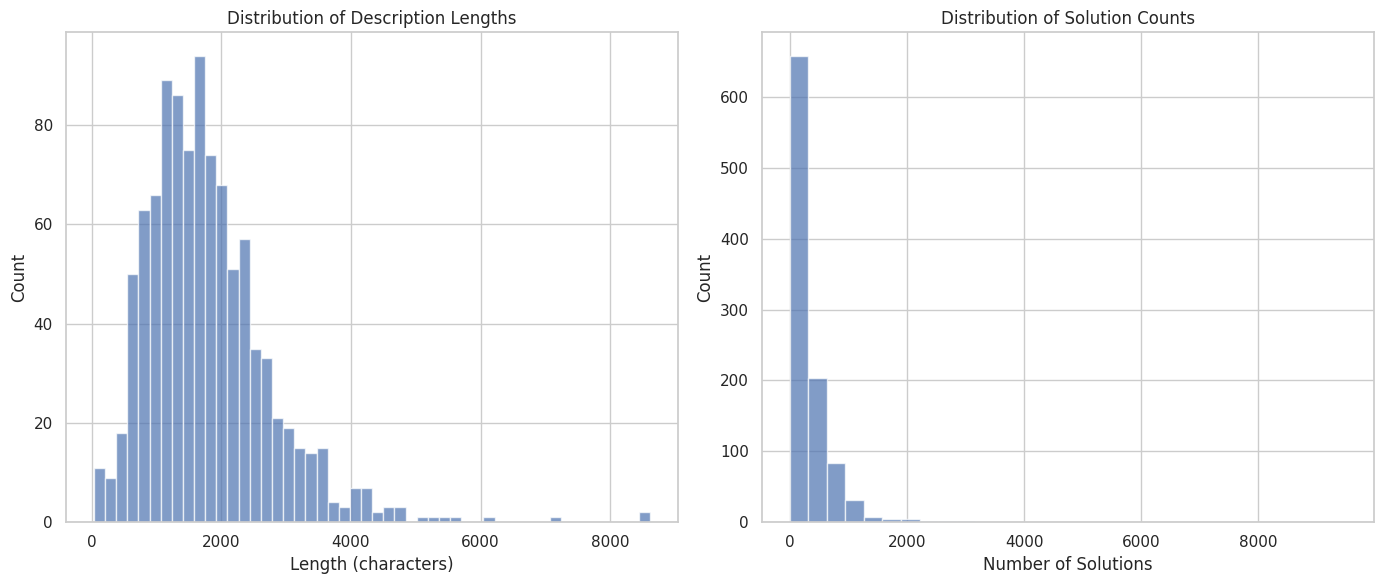

In [11]:
# Create histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(train_analysis['desc_lengths'], bins=50, alpha=0.7)
plt.title('Distribution of Description Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(train_analysis['solution_counts'], bins=min(30, max(train_analysis['solution_counts'])), alpha=0.7)
plt.title('Distribution of Solution Counts')
plt.xlabel('Number of Solutions')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('description_solution_dist.png')
print("\nSaved histogram plot as 'description_solution_dist.png'")


In [12]:
# Clean up for memory efficiency
plt.close('all')
force_gc()

In [13]:
# Analyze test cases
def analyze_test_cases(dataset_split):
    # Take a smaller sample for analysis
    sample_size = min(1000, len(dataset_split))
    sample = dataset_split.select(range(sample_size))

    public_test_counts = [len(item['input']) for item in sample['public_tests']]
    private_test_counts = [len(item['input']) for item in sample['private_tests']]
    generated_test_counts = [len(item['input']) for item in sample['generated_tests']]

    # Calculate statistics
    avg_public = np.mean(public_test_counts)
    avg_private = np.mean(private_test_counts)
    avg_generated = np.mean(generated_test_counts)

    return {
        'public_test_counts': public_test_counts,
        'private_test_counts': private_test_counts,
        'generated_test_counts': generated_test_counts,
        'avg_public': avg_public,
        'avg_private': avg_private,
        'avg_generated': avg_generated
    }

# Analyze train set test cases
print("\nAnalyzing test cases...")
test_analysis = analyze_test_cases(dataset['train'])

# Print statistics
print("\nTest Case Statistics (Train):")
print(f"Average Public Tests: {test_analysis['avg_public']:.2f}")
print(f"Average Private Tests: {test_analysis['avg_private']:.2f}")
print(f"Average Generated Tests: {test_analysis['avg_generated']:.2f}")



Analyzing test cases...

Test Case Statistics (Train):
Average Public Tests: 1.99
Average Private Tests: 14.40
Average Generated Tests: 77.54



Saved test case histogram as 'test_case_dist.png'


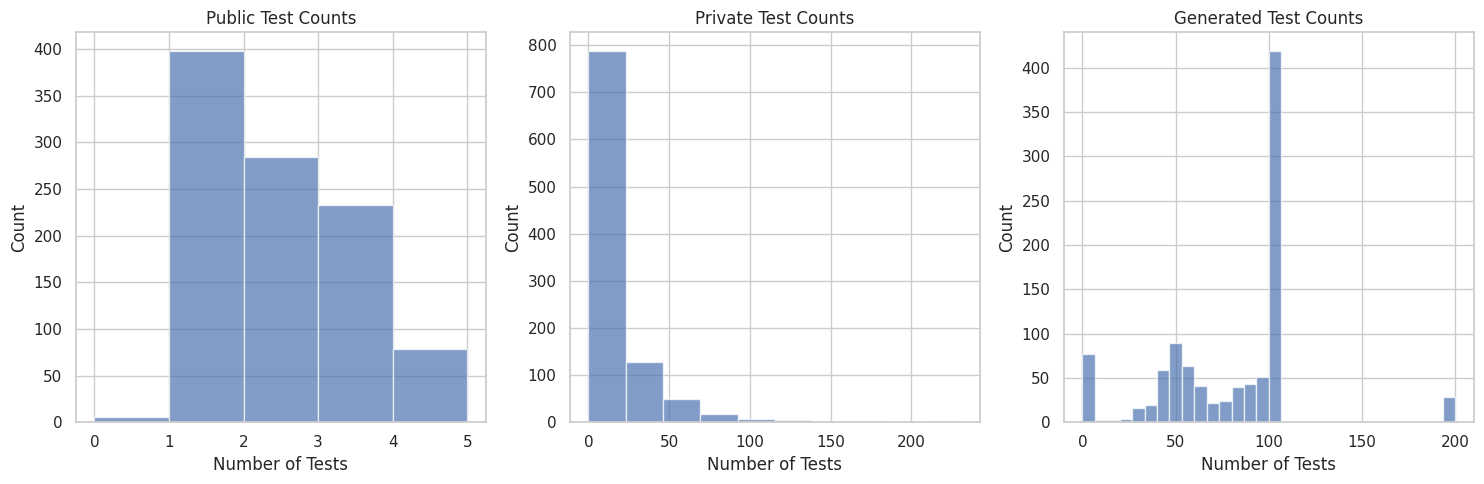

In [14]:
# Create histograms for test cases
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(test_analysis['public_test_counts'], bins=min(10, max(test_analysis['public_test_counts'])), alpha=0.7)
plt.title('Public Test Counts')
plt.xlabel('Number of Tests')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(test_analysis['private_test_counts'], bins=min(10, max(test_analysis['private_test_counts']) + 1), alpha=0.7)
plt.title('Private Test Counts')
plt.xlabel('Number of Tests')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(test_analysis['generated_test_counts'], bins=30, alpha=0.7)
plt.title('Generated Test Counts')
plt.xlabel('Number of Tests')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('test_case_dist.png')
print("\nSaved test case histogram as 'test_case_dist.png'")

In [15]:
# Analyze solution complexity - simplified to save memory
def analyze_solution_complexity(dataset_split):
    # Take a smaller sample for analysis
    sample_size = min(500, len(dataset_split))
    sample = dataset_split.select(range(sample_size))

    # Get all solutions
    solution_texts = []
    solution_languages = []

    for item_idx, item in enumerate(sample['solutions']):
        solutions = item['solution']
        languages = item['language']

        for sol_idx in range(len(solutions)):
            solution_texts.append(solutions[sol_idx])
            solution_languages.append(languages[sol_idx])

    # Calculate lengths
    solution_lengths = [len(sol) for sol in solution_texts]

    # Calculate lines of code
    solution_loc = [len(sol.split('\n')) for sol in solution_texts]

    # Group by language
    language_names = dataset_split.features['solutions'].feature['language'].names
    languages = set(solution_languages)
    language_lengths = {language_names[lang]: [] for lang in languages}
    language_loc = {language_names[lang]: [] for lang in languages}

    for lang, length, loc in zip(solution_languages, solution_lengths, solution_loc):
        language_lengths[language_names[lang]].append(length)
        language_loc[language_names[lang]].append(loc)

    return {
        'solution_lengths': solution_lengths,
        'solution_loc': solution_loc,
        'language_lengths': language_lengths,
        'language_loc': language_loc
    }

# Analyze solution complexity
print("\nAnalyzing solution complexity...")
solution_analysis = analyze_solution_complexity(dataset['train'])

# Print statistics
print("\nSolution Length Statistics (Train):")
print(f"Average Length: {np.mean(solution_analysis['solution_lengths']):.2f} characters")
print(f"Average LOC: {np.mean(solution_analysis['solution_loc']):.2f} lines")

print("\nSolution Length by Language:")
for lang in solution_analysis['language_lengths']:
    if solution_analysis['language_lengths'][lang]:
        avg_length = np.mean(solution_analysis['language_lengths'][lang])
        avg_loc = np.mean(solution_analysis['language_loc'][lang])
        print(f"{lang}: Avg Length = {avg_length:.2f}, Avg LOC = {avg_loc:.2f}")



Analyzing solution complexity...

Solution Length Statistics (Train):
Average Length: 1185.05 characters
Average LOC: 51.07 lines

Solution Length by Language:
PYTHON: Avg Length = 498.21, Avg LOC = 23.87
CPP: Avg Length = 1192.65, Avg LOC = 51.99
PYTHON3: Avg Length = 450.25, Avg LOC = 22.14
JAVA: Avg Length = 2640.70, Avg LOC = 107.24



Saved solution length boxplot as 'solution_lengths_by_language.png'


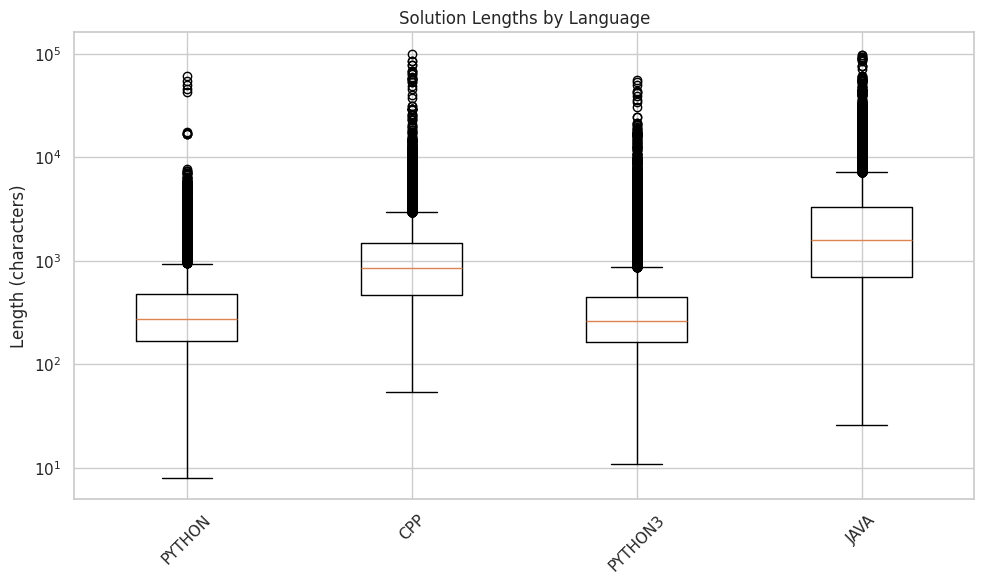

In [16]:
# Create boxplots for solution lengths by language
plt.figure(figsize=(10, 6))
lang_data = []
lang_names = []

for lang in solution_analysis['language_lengths']:
    if solution_analysis['language_lengths'][lang] and lang != 'UNKNOWN_LANGUAGE':
        lang_data.append(solution_analysis['language_lengths'][lang])
        lang_names.append(lang)

plt.boxplot(lang_data)
plt.xticks(range(1, len(lang_names) + 1), lang_names, rotation=45)
plt.title('Solution Lengths by Language')
plt.ylabel('Length (characters)')
plt.yscale('log')  # Using log scale for better visualization
plt.tight_layout()
plt.savefig('solution_lengths_by_language.png')
print("\nSaved solution length boxplot as 'solution_lengths_by_language.png'")

In [17]:
# Clean up for memory efficiency
plt.close('all')
force_gc()

In [18]:
print("\n" + "="*50)
print("PART 2: PREPARE DATA FOR TRAINING")
print("="*50)


PART 2: PREPARE DATA FOR TRAINING


In [19]:
# Load the CodeT5 tokenizer
print("\nLoading CodeT5 tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-small")


Loading CodeT5 tokenizer...


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

In [20]:
# Set max lengths for inputs and outputs - reducing to save memory
max_source_length = 256  # Reduced from 512
max_target_length = 256  # Reduced from 512

# Function to prepare dataset for training - modified to process in batches
def prepare_dataset_for_training(dataset_split, tokenizer, max_source_length=256, max_target_length=256,
                                target_language=1, batch_size=50):
    """
    Prepare dataset for training CodeT5 model.
    target_language=1 is PYTHON according to the ClassLabel mapping
    Process in smaller batches to save memory
    """
    print(f"Preparing dataset with {len(dataset_split)} examples...")

    all_input_ids = []
    all_attention_masks = []
    all_labels = []
    all_raw_inputs = []
    all_raw_targets = []
    filtered_count = 0

    # Process in batches
    for start_idx in tqdm(range(0, len(dataset_split), batch_size)):
        end_idx = min(start_idx + batch_size, len(dataset_split))
        batch = dataset_split.select(range(start_idx, end_idx))

        batch_inputs = []
        batch_targets = []

        for item in batch:
            # Get problem description and test cases for context
            description = item['description']

            # Add test cases to the input for context - shortened to include just 1 test case
            if len(item['public_tests']['input']) > 0:
                test_input = item['public_tests']['input'][0]
                test_output = item['public_tests']['output'][0]
                # Use shorter context to save tokens
                context = f"Description: {description[:1000]}\nInput: {test_input[:200]}\nOutput: {test_output[:200]}"
            else:
                context = f"Description: {description[:1000]}"

            # Get Python solutions if available (target_language=1 is PYTHON)
            python_solutions = []
            for i, lang in enumerate(item['solutions']['language']):
                if lang == target_language:
                    python_solutions.append(item['solutions']['solution'][i])
                    break  # Just get the first Python solution to save memory

            # Skip if no Python solutions
            if not python_solutions:
                filtered_count += 1
                continue

            # Add to inputs and targets (using first Python solution)
            batch_inputs.append(context)
            batch_targets.append(python_solutions[0])

        # Skip empty batches
        if not batch_inputs:
            continue

        # Tokenize batch
        tokenized_inputs = tokenizer(
            batch_inputs,
            padding="max_length",
            truncation=True,
            max_length=max_source_length,
            return_tensors="pt"
        )

        tokenized_targets = tokenizer(
            batch_targets,
            padding="max_length",
            truncation=True,
            max_length=max_target_length,
            return_tensors="pt"
        )

        # Replace padding token id's with -100 in labels
        labels = [[label if label != tokenizer.pad_token_id else -100 for label in labels]
                 for labels in tokenized_targets.input_ids]

        # Add to our lists
        all_input_ids.extend(tokenized_inputs.input_ids.tolist())
        all_attention_masks.extend(tokenized_inputs.attention_mask.tolist())
        all_labels.extend(labels)
        all_raw_inputs.extend(batch_inputs)
        all_raw_targets.extend(batch_targets)

        # Force garbage collection after each batch
        force_gc()

    print(f"Filtered out {filtered_count} examples without Python solutions")
    print(f"Final dataset size: {len(all_input_ids)} examples")

    # Create dataset dictionary
    dataset_dict = {
        "input_ids": all_input_ids,
        "attention_mask": all_attention_masks,
        "labels": all_labels,
        "raw_inputs": all_raw_inputs,
        "raw_targets": all_raw_targets
    }

    return Dataset.from_dict(dataset_dict)

In [21]:
# Use smaller subsets for faster processing during development
# For a real training run, you'd want to use the full dataset
print("\nPreparing datasets for training...")
SAMPLE_SIZE = {
    'train': 2000,  # Use a smaller subset for faster training
    'validation': 200,
    'test': 200
}


Preparing datasets for training...


In [22]:
from datasets import DatasetDict

# Check existing splits
print(dataset)

# If 'validation' split doesn't exist, create it from train split
if 'validation' not in dataset:
    # Split train into train and validation (e.g., 90% train, 10% validation)
    train_val = dataset['train'].train_test_split(test_size=0.1, seed=42)
    dataset = DatasetDict({
        'train': train_val['train'],
        'validation': train_val['test'],
        'test': dataset['test'] if 'test' in dataset else train_val['test'],  # fallback if 'test' doesn't exist
    })


DatasetDict({
    train: Dataset({
        features: ['name', 'description', 'public_tests', 'private_tests', 'generated_tests', 'source', 'difficulty', 'solutions', 'incorrect_solutions', 'cf_contest_id', 'cf_index', 'cf_points', 'cf_rating', 'cf_tags', 'is_description_translated', 'untranslated_description', 'time_limit', 'memory_limit_bytes', 'input_file', 'output_file'],
        num_rows: 13328
    })
    test: Dataset({
        features: ['name', 'description', 'public_tests', 'private_tests', 'generated_tests', 'source', 'difficulty', 'solutions', 'incorrect_solutions', 'cf_contest_id', 'cf_index', 'cf_points', 'cf_rating', 'cf_tags', 'is_description_translated', 'untranslated_description', 'time_limit', 'memory_limit_bytes', 'input_file', 'output_file'],
        num_rows: 165
    })
    valid: Dataset({
        features: ['name', 'description', 'public_tests', 'private_tests', 'generated_tests', 'source', 'difficulty', 'solutions', 'incorrect_solutions', 'cf_contest_id', 'cf_ind

In [23]:
# Prepare datasets with smaller batch sizes
train_dataset = prepare_dataset_for_training(
    dataset['train'].select(range(min(SAMPLE_SIZE['train'], len(dataset['train'])))),
    tokenizer,
    batch_size=40  # Process in smaller batches
)

val_dataset = prepare_dataset_for_training(
    dataset['validation'].select(range(min(SAMPLE_SIZE['validation'], len(dataset['validation'])))),
    tokenizer,
    batch_size=40
)

test_dataset = prepare_dataset_for_training(
    dataset['test'].select(range(min(SAMPLE_SIZE['test'], len(dataset['test'])))),
    tokenizer,
    batch_size=40
)

print(f"\nPrepared training dataset with {len(train_dataset)} examples")
print(f"Prepared validation dataset with {len(val_dataset)} examples")
print(f"Prepared testing dataset with {len(test_dataset)} examples")


Preparing dataset with 2000 examples...


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


Filtered out 664 examples without Python solutions
Final dataset size: 1336 examples
Preparing dataset with 200 examples...


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Filtered out 69 examples without Python solutions
Final dataset size: 131 examples
Preparing dataset with 165 examples...


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Filtered out 78 examples without Python solutions
Final dataset size: 87 examples

Prepared training dataset with 1336 examples
Prepared validation dataset with 131 examples
Prepared testing dataset with 87 examples


In [24]:
# Clean up for memory efficiency
del dataset
force_gc()


In [25]:
print("\n" + "="*50)
print("PART 3: TRAIN CODE-T5 MODEL")
print("="*50)


PART 3: TRAIN CODE-T5 MODEL


In [27]:
!pip install rouge_score
# Set up evaluation metrics - simplified to use less memory
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Only use ROUGE for evaluation to save computation and memory
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Only calculate ROUGE scores to save memory
    rouge_scores = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    result = {
        "rouge1": rouge_scores["rouge1"],
        "rouge2": rouge_scores["rouge2"],
        "rougeL": rouge_scores["rougeL"],
    }

    return result

# Load ROUGE metric
rouge = evaluate.load("rouge")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=01f730ebc1172bdc4976559deb86f29d2e6a095fee2226f87c4dd51bbd9f32ea
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [28]:
# Load pre-trained model
print("\nLoading pre-trained CodeT5 model...")
model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-small")


Loading pre-trained CodeT5 model...


config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [29]:
from transformers import TrainingArguments

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

# Define training arguments
print("\nSetting up training arguments...")
output_dir = "./codet5_finetuned_code_contests"
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,  # Reduced from 4 to save memory
    per_device_eval_batch_size=1,   # Reduced from 4 to save memory
    num_train_epochs=1,             # Reduced from 3 to save time
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=50,               # Reduced from 100 to get more frequent updates
    save_total_limit=1,             # Only save the best model to save disk space
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    remove_unused_columns=False,    # Important to keep our custom columns
    fp16=True,
    report_to=[],                                # Enable mixed precision training to save memory
    gradient_accumulation_steps=2,  # Accumulate gradients over multiple steps
    eval_accumulation_steps=4,      # Accumulate eval gradients to save memory during eval
    dataloader_num_workers=2,       # Use multiple workers for data loading
    optim="adamw_torch",
    # Use torch's optimizer which can be more memory efficient
)


Setting up training arguments...


In [30]:
# Initialize Trainer
print("\nInitializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


Initializing Trainer...


In [ ]:
# Start training with memory monitoring
print("\nStarting training...")
try:
    # Add memory monitoring
    print("\nMemory usage before training:")
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    trainer.train()

    print("\nTraining completed successfully!")

    print("\nMemory usage after training:")
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

except Exception as e:
    print(f"\nTraining error: {e}")
    # If training fails, try with even more memory reduction
    print("\nAttempting training with more aggressive memory optimization...")

    # Clear memory
    del trainer
    del model
    force_gc()

    print("\nLoading pre-trained CodeT5 model again with reduced size...")
    # Try tiny model instead
    try:
        model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-small",
                                                         low_cpu_mem_usage=True)
        model.gradient_checkpointing_enable()

        # More aggressive training settings
        training_args = TrainingArguments(
            output_dir=output_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=5e-5,
            per_device_train_batch_size=1,  # Minimum batch size
            per_device_eval_batch_size=1,   # Minimum batch size
            num_train_epochs=1,
            weight_decay=0.01,
            push_to_hub=False,
            logging_dir='./logs',
            logging_steps=25,
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="rougeL",
            remove_unused_columns=False,
            fp16=True,
            gradient_accumulation_steps=4,  # Increased accumulation
            dataloader_num_workers=1,       # Reduced workers
            optim="adamw_torch",
            max_grad_norm=0.5,
            report_to=[]                               # Limit gradient magnitude
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        print("\nReduced settings training completed successfully!")
    except Exception as e2:
        print(f"\nSecond training attempt error: {e2}")
        print("\nContinuing with evaluation using the last checkpoint if available...")



Starting training...

Memory usage before training:
GPU memory allocated: 230.76 MB
GPU memory reserved: 238.00 MB


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.



Training error: argument 'ids': 'list' object cannot be interpreted as an integer

Attempting training with more aggressive memory optimization...

Loading pre-trained CodeT5 model again with reduced size...


Epoch,Training Loss,Validation Loss


In [1]:
print("\n" + "="*50)
print("PART 4: EVALUATE THE MODEL")
print("="*50)


PART 4: EVALUATE THE MODEL


In [ ]:
# Evaluate on validation set - with memory tracking
print("\nEvaluating on validation set...")
try:
    val_results = trainer.evaluate(eval_dataset=val_dataset)
    print(f"Validation Results: {val_results}")
except Exception as e:
    print(f"Evaluation error: {e}")
    print("Skipping full evaluation due to memory constraints.")
    val_results = {"error": "Memory limit exceeded during evaluation"}


In [ ]:
# Force GC
force_gc()

In [ ]:
# Function to generate code solution with careful memory management
def generate_code_solution(problem_description, model, tokenizer, test_input=None, test_output=None,
                          max_source_length=384, max_target_length=384):
    # Truncate inputs to fit in memory
    problem_description = problem_description[:1000]  # Limit description length
    if test_input and test_output:
        test_input = test_input[:200]  # Limit test input length
        test_output = test_output[:200]  # Limit test output length
        context = f"Description: {problem_description}\nInput: {test_input}\nOutput: {test_output}"
    else:
        context = f"Description: {problem_description}"

    # Tokenize with careful memory management
    inputs = tokenizer(context, return_tensors="pt", max_length=max_source_length, truncation=True)
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # Generate output with memory efficient settings
    with torch.no_grad():  # Disable gradient calculation to save memory
        output_sequences = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_target_length,
            num_beams=3,  # Reduced from 5 to save memory
            early_stopping=True,
            do_sample=False  # Deterministic generation uses less memory
        )

    # Move tensors to CPU before decoding
    if torch.cuda.is_available():
        output_sequences = output_sequences.cpu()

    # Decode the output
    generated_code = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

    # Force memory cleanup
    del inputs, output_sequences
    force_gc()

    return generated_code

In [ ]:
# Test with fewer examples to save memory
print("\nTesting with sample problems from test set:")
print("-" * 80)

In [ ]:
example_count = min(3, len(test_dataset))  # Reduced from 5 to 3
for i in range(example_count):
    example = test_dataset[i]
    problem_desc = example["raw_inputs"]
    actual_solution = example["raw_targets"]

    # Extract test input and output if available
    if "Test Input:" in problem_desc or "Input:" in problem_desc:
        if "Test Input:" in problem_desc:
            parts = problem_desc.split("Test Input:", 1)
        else:
            parts = problem_desc.split("Input:", 1)

        desc = parts[0].replace("Description: ", "").strip()

        if "Test Output:" in parts[1]:
            test_parts = parts[1].split("Test Output:", 1)
        elif "Output:" in parts[1]:
            test_parts = parts[1].split("Output:", 1)
        else:
            test_parts = [parts[1], ""]

        test_input = test_parts[0].strip()
        test_output = test_parts[1].strip() if len(test_parts) > 1 else ""
    else:
        desc = problem_desc.replace("Description: ", "").strip()
        test_input = ""
        test_output = ""

    print(f"\nExample {i+1}:")
    print(f"Problem Description: {desc[:200]}...")

    try:
        # Generate solution
        generated_solution = generate_code_solution(desc, model, tokenizer, test_input, test_output)

        print(f"\nGenerated Solution:")
        print("-" * 40)
        print(generated_solution[:500] + "..." if len(generated_solution) > 500 else generated_solution)
        print("-" * 40)

        print(f"\nActual Solution:")
        print("-" * 40)
        print(actual_solution[:500] + "..." if len(actual_solution) > 500 else actual_solution)
        print("-" * 80)
    except Exception as e:
        print(f"Error generating solution: {e}")
        continue

    # Force garbage collection after each example
    force_gc()
